# Attribute Importance for Concept Drift - Primary and Secondary Drift Detection in one dataset

This notebook allows to detect primary and related secondary driftpoints according to the master thesis' framework.

The user specifies a file path for the dataset to analyze and builds the primary as well as secondary drift detectors.

Outputs are graphs as well as drift point lists.

## Setup
### Imports

In [24]:
# imports
import helper
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import population_comparison
from processdrift.framework import windowing
from processdrift.framework import change_point_extraction


import math
import pandas as pd

### Data settings and event log loading

In [25]:
# data settings
data_file_path = 'data/synthetic/attribute_drift/sudden_3_attribute_values/10000/cf10k_0bbd4c9b-97ca-4594-ad55-32d3686e7756.xes' # + 'data\\synthetic\\maardji et al 2013_xes_attributes\\logs\\cb\\cb2.5k.xes' # 

# load event log
event_log = xes_importer.apply(data_file_path)

parsing log, completed traces :: 100%|██████████| 10000/10000 [00:06<00:00, 1434.77it/s]


### Configure Primary Drift Detector

In [26]:
# alternative 1: ProDrift Drift detector
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=200,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [27]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

primary_window_size = 200
primary_slide_by = 10
primary_feature_extractor = feature_extraction.RunsFE()
primary_window_generator = windowing.FixedWG(window_size=primary_window_size, slide_by=primary_slide_by)
primary_population_comparer = population_comparison.GTestPC(0)

primary_threshold = 0.05
primary_phi = math.ceil(primary_window_size / primary_slide_by * 0.5)
primary_rho = 3
print(f"primary_phi={primary_phi}, primary_rho={primary_rho}")

primary_change_point_extractor = change_point_extraction.PhiFilterCPE(primary_threshold, primary_phi, primary_rho)

primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)

primary_phi=10, primary_rho=3


In [28]:
# alternative 3: drift detector true known
# primary_process_drift_detector = drift_detection.TrueKnownDD(helper.get_change_points_maardji_et_al_2013(len(event_log)))

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [29]:
secondary_window_size = 200
secondary_slide_by = 10
secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)
secondary_threshold = 0.05
secondary_max_distance = 300

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by / 2)
secondary_rho = 1
print(f"secondary_phi={secondary_phi}, secondary_rho={secondary_rho}")

secondary_change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

attribute_level_types = helper.get_attributes_and_types_for_synthetic_data()

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_types,
                                                                         secondary_window_generator, 
                                                                         change_point_extractor=secondary_change_point_extractor)

secondary_phi=10, secondary_rho=1


## Run the Change Point Explainer

In [30]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
possible_drift_explanations = drift_explainer.get_possible_drift_explanations(event_log, max_distance=secondary_max_distance)

In [31]:
# show the possible change point explanations
possible_drift_explanations.possible_drift_explanations

{1029: [{'detector': 'relevant_attribute_01',
   'change_point': 1018,
   'distance': -11}],
 2029: [{'detector': 'relevant_attribute_02',
   'change_point': 2028,
   'distance': -1}],
 3019: [{'detector': 'relevant_attribute_03',
   'change_point': 3068,
   'distance': 49}],
 4049: [{'detector': 'relevant_attribute_04',
   'change_point': 4018,
   'distance': -31},
  {'detector': 'relevant_attribute_03', 'change_point': 3968, 'distance': -81},
  {'detector': 'irrelevant_attribute_04',
   'change_point': 3758,
   'distance': -291}],
 5009: [{'detector': 'relevant_attribute_05',
   'change_point': 5028,
   'distance': 19}],
 6029: [],
 7009: [],
 8049: [{'detector': 'irrelevant_attribute_02',
   'change_point': 8068,
   'distance': 19},
  {'detector': 'irrelevant_attribute_02',
   'change_point': 7818,
   'distance': -231}],
 9019: [{'detector': 'irrelevant_attribute_01',
   'change_point': 9198,
   'distance': 179}]}

<AxesSubplot:>

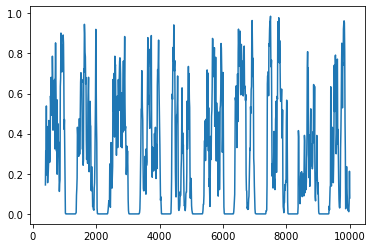

In [32]:
possible_drift_explanations.primary_dd_result.change_series.plot()

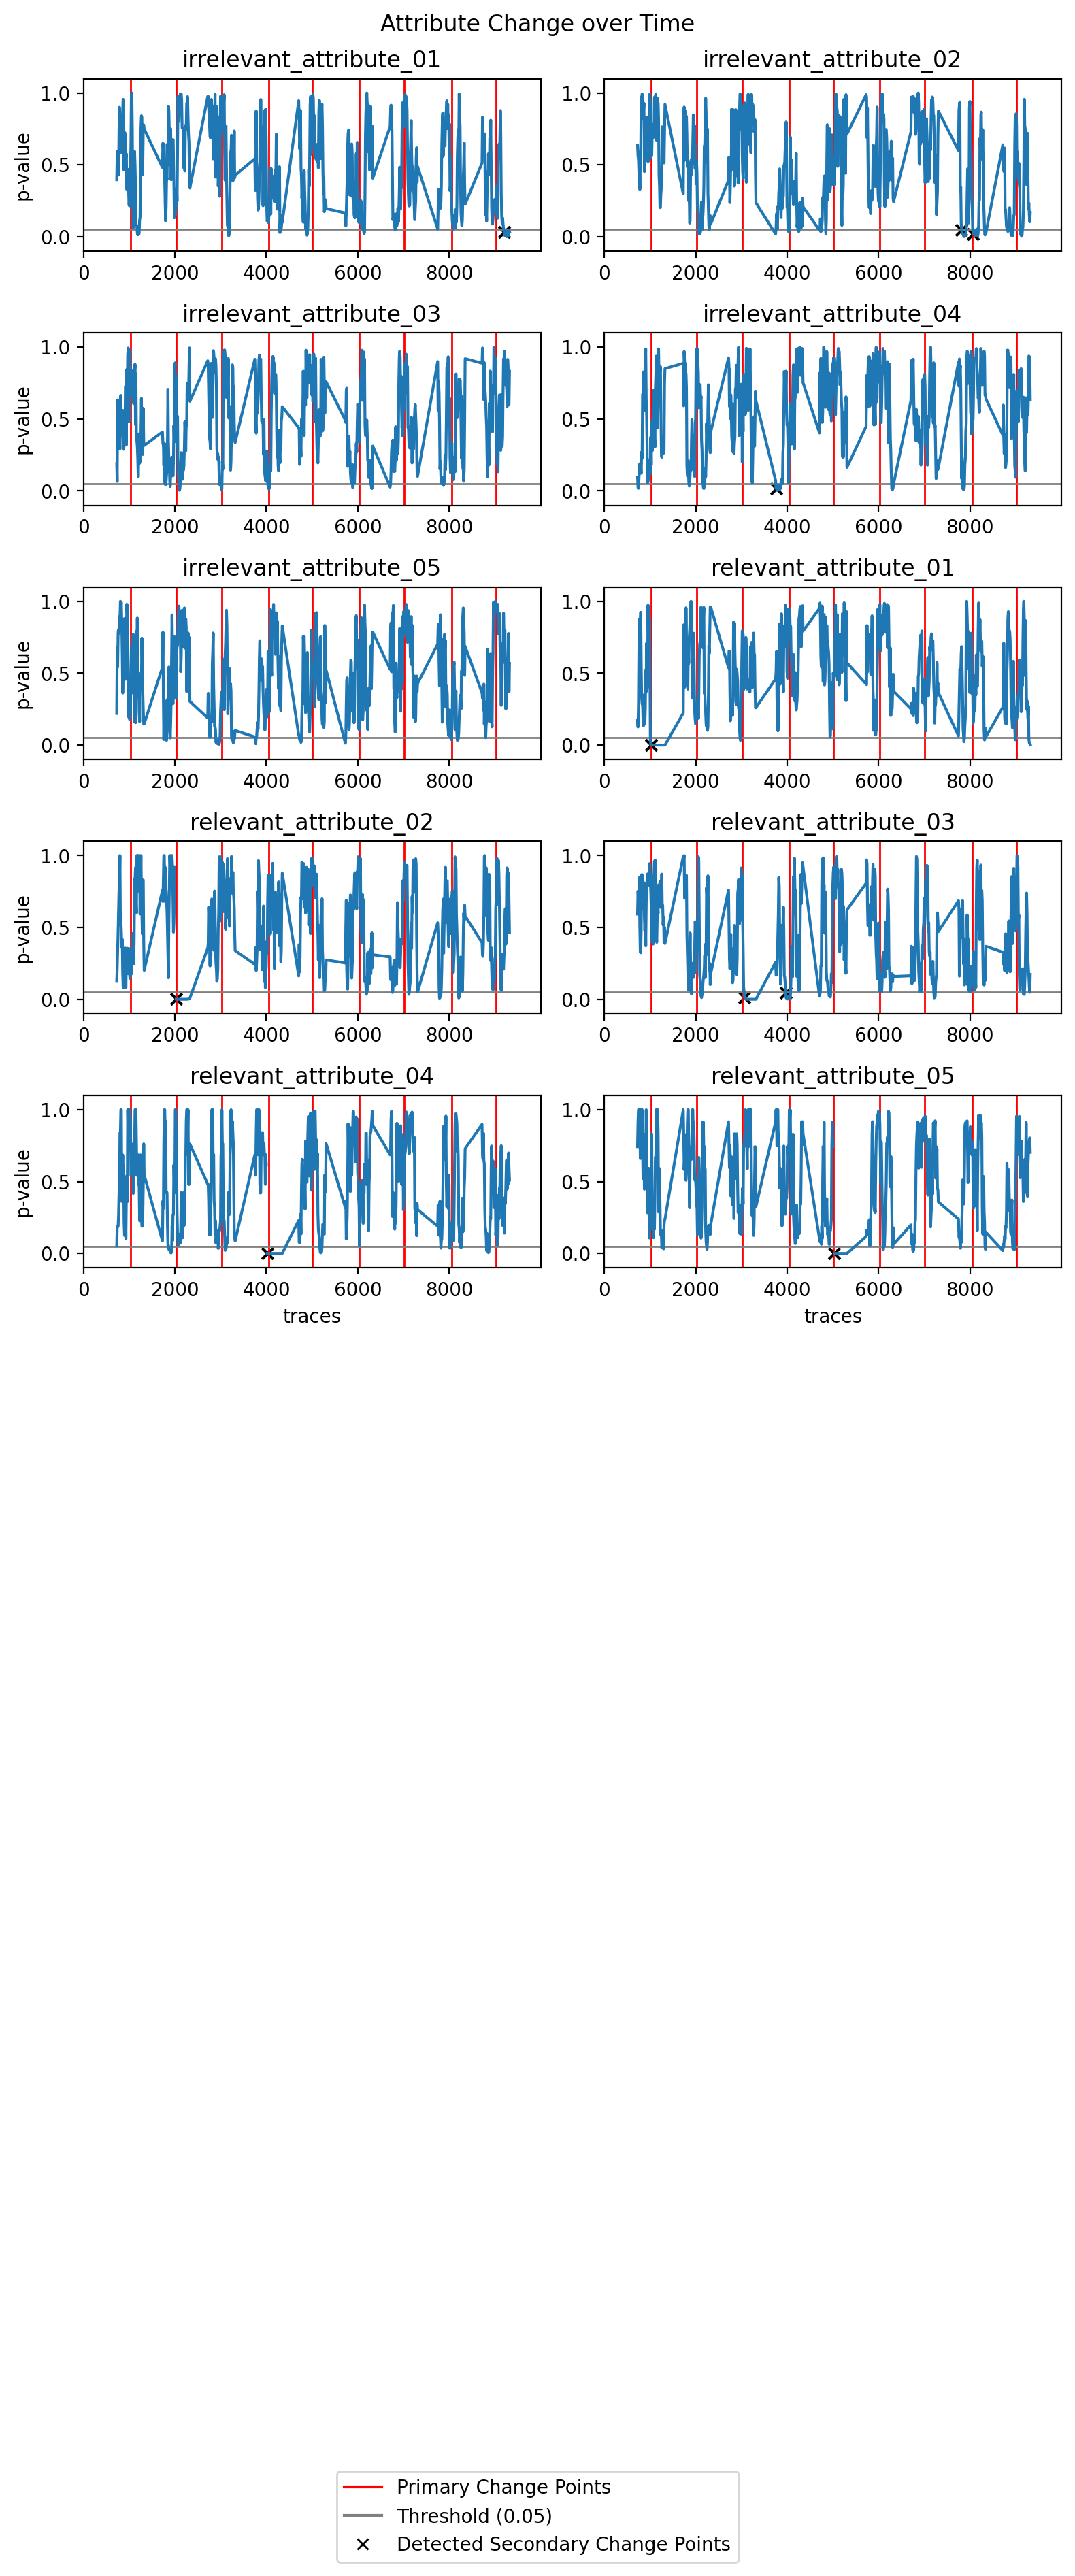

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [33]:
# plot the drift explanations
possible_drift_explanations.plot(offset_legend=-0.9)

## Perform Runtime Analysis

In [34]:
import cProfile
cProfile.run('drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)', 'profile.stats')

import pstats
p = pstats.Stats("profile.stats")
p.sort_stats(pstats.SortKey.CUMULATIVE)
p.print_stats()

NameError: name 'max_distance' is not defined

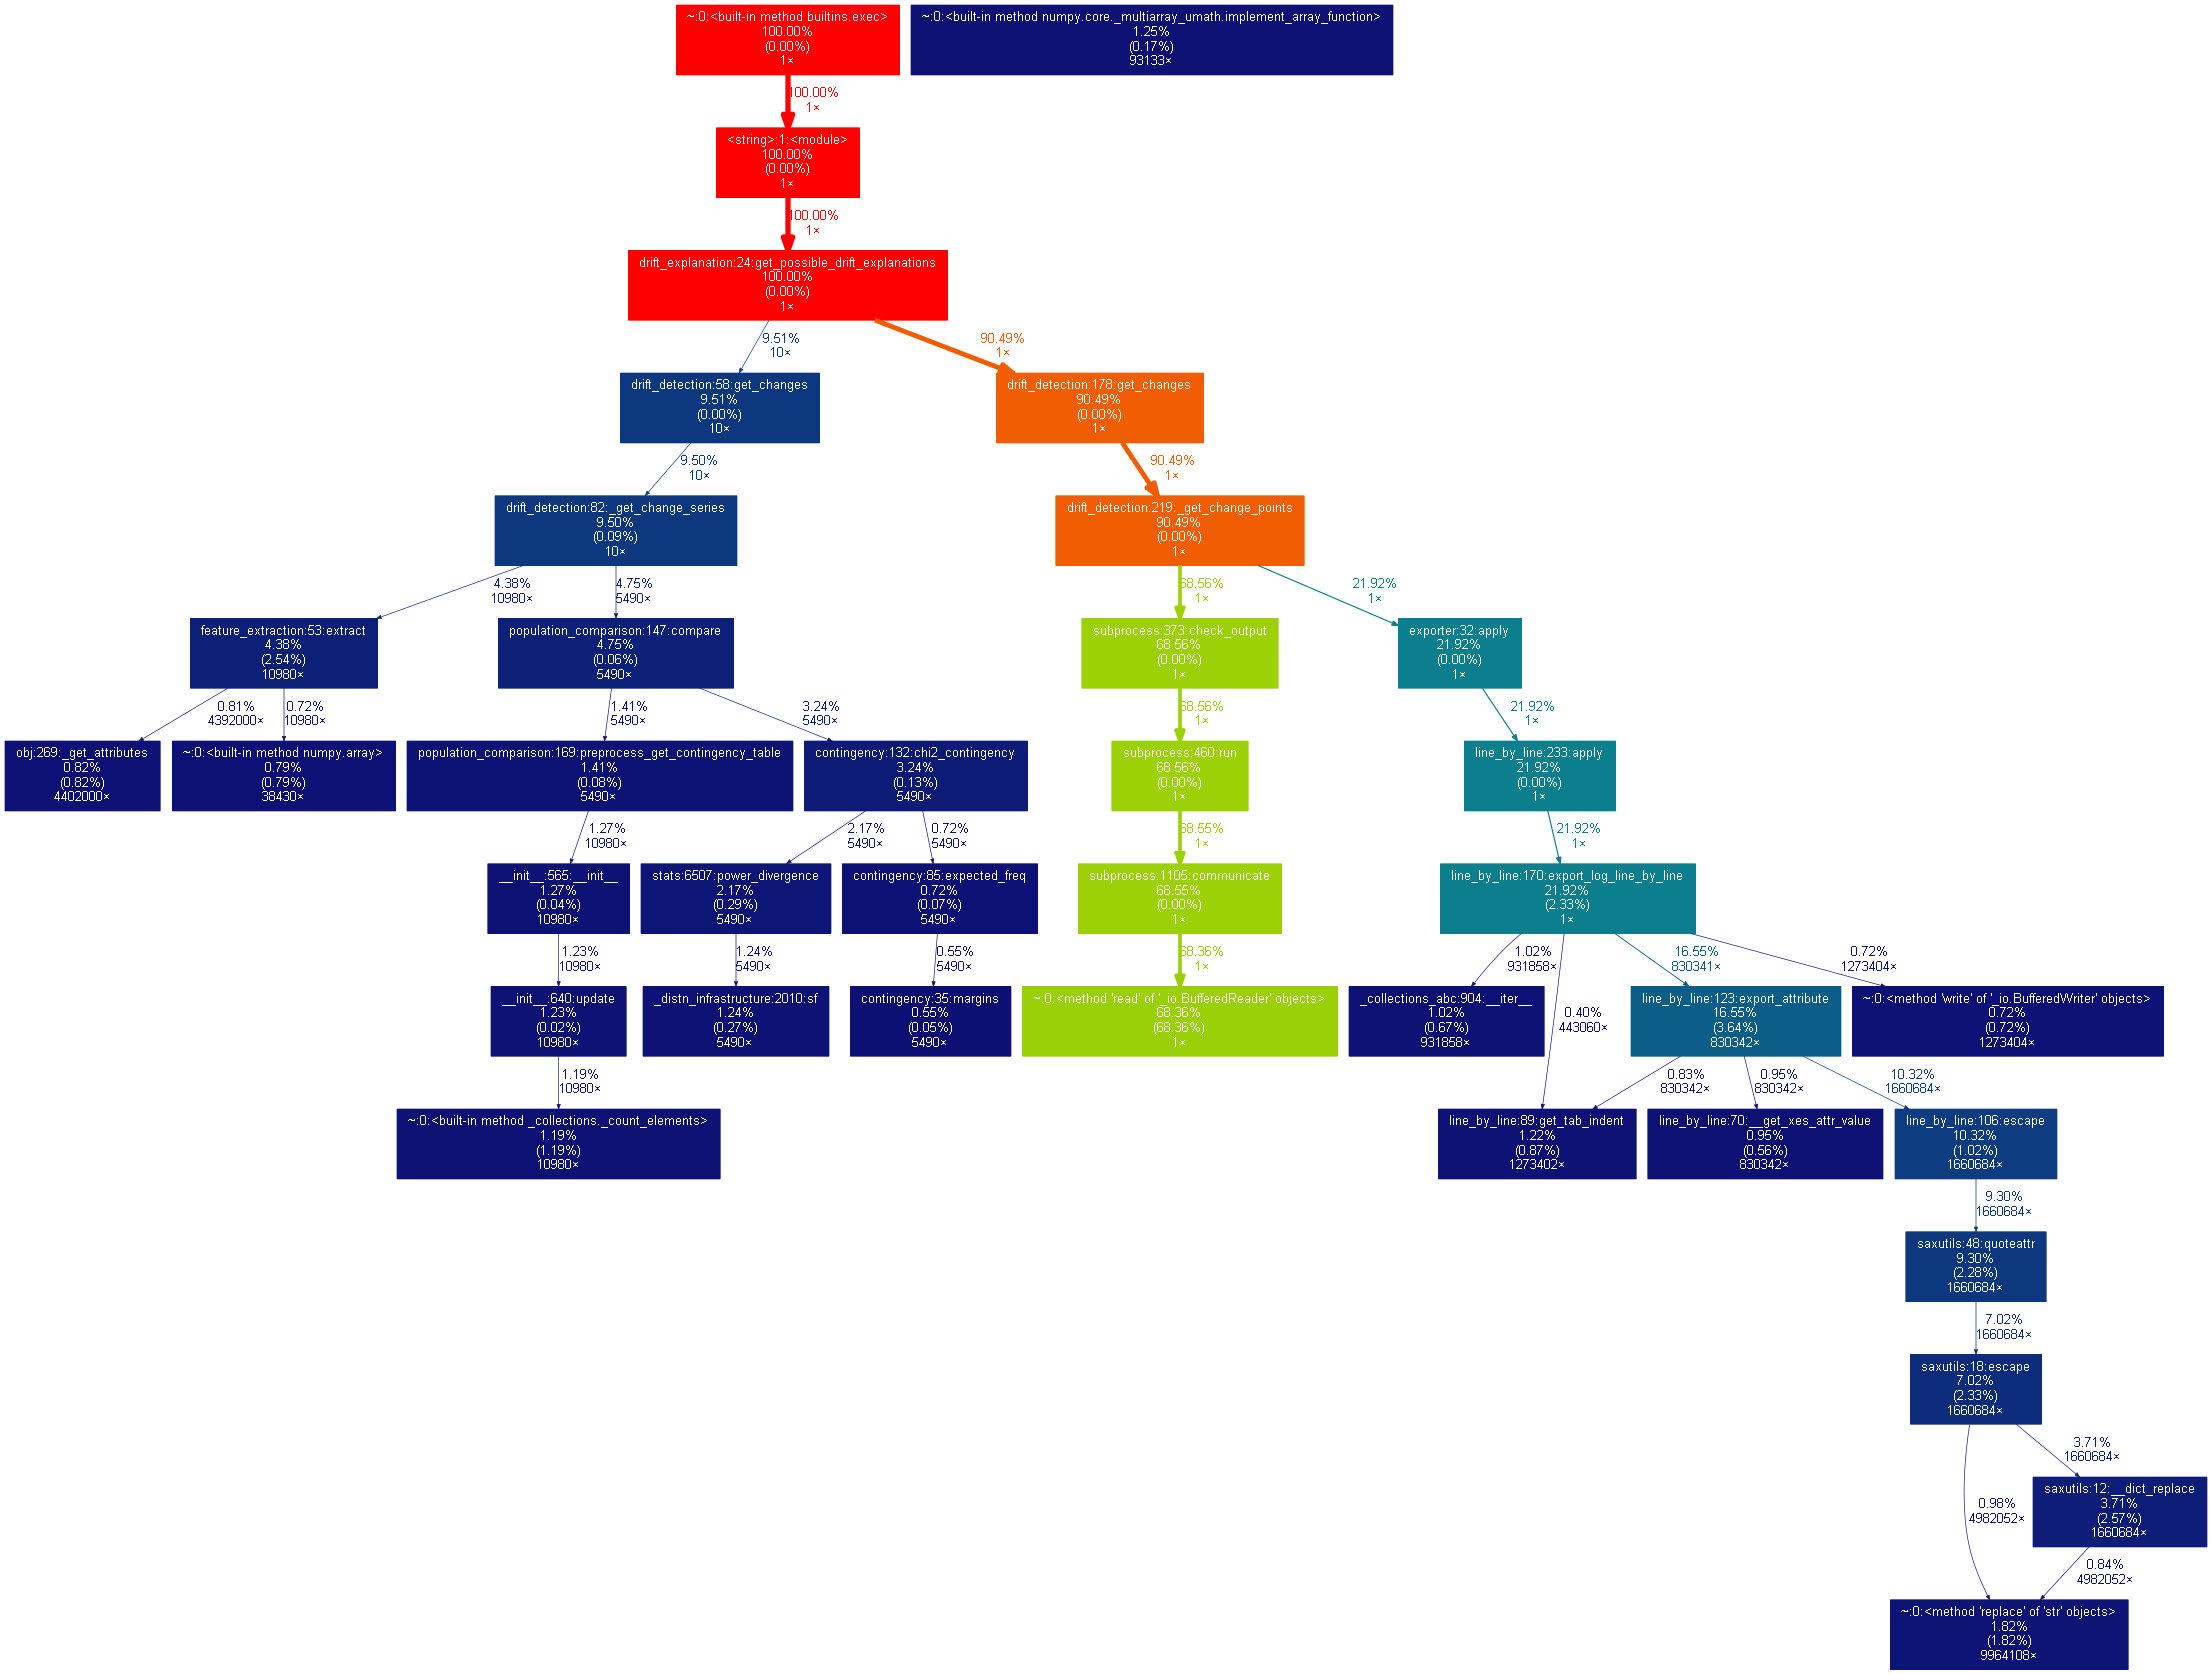

In [ ]:
!gprof2dot profile.stats -f pstats | dot -Tpng -o output.png

from IPython.display import Image
Image(filename='output.png') 